# Receiver function, python interface

So you should already have been through the notebook showing the YAML interface. If not, do that first, as this notebook skips all the build steps required to compile code into something that CoFI can work with.

So off the bat, I am going to be assuming you have compiled code into a shared library and it is wrapped in the right way to interact with CoFI (i.e. `cofi_init` and `cofi_misfit`) are implemented and wrapped/annotated.


In [1]:
# Import and initialize
import numpy as np
import os
import sys
from plotnine import *
import pandas as pd
sys.path.append("/home/peter/personal/CoFI/")
import cofi_core
from cofi_core import DumbDescent 
from cofi_core import Model
np.random.seed(60065)

# Step 1: import your code 

If you have built your shared library you just need to make sure it is in the python library path, and then import it.

In [2]:
OBJDIR="/home/peter/personal/CoFI/user_testing/rfc"
sys.path.append(OBJDIR)
import rfc 

We can just check that we have the cofi_init routine. In this case I have set it up so we can pass in some parameters
for the receiver function.

In [3]:
print(rfc.cofi_init.__doc__)

cofi_init(fs0,gauss_a0,water_c0,true_model)

Wrapper for ``cofi_init``.

Parameters
----------
fs0 : input float
gauss_a0 : input float
water_c0 : input float
true_model : input rank-2 array('f') with bounds (7,3)



We can call cofi_init. In this case calling it with (amongst other things) the true/reference model

In [4]:
true_model = np.array([[8.370596, 3.249075, 1.7],
[17.23163, 3.001270, 1.7],
[1.9126695E-02, 2.509443, 1.7],
[19.78145, 3.562691, 1.7],
[41.73066, 4.225965, 1.7],
[14.35261, 2.963322, 1.7],
[49.92358, 4.586726, 1.7]])

rfc.cofi_init(25.0, 2.1, 0.0001, true_model)

Now we can check we have a cofi_misfit() routine, and what it looks like. Here we see it takes a model and returns 3 values: the misfit of the model, the receiver function produced by those model parameters, and the true receiver function

In [5]:
print(rfc.cofi_misfit.__doc__)

misfit,value_pred,value_obs = cofi_misfit(model)

Wrapper for ``cofi_misfit``.

Parameters
----------
model : input rank-2 array('f') with bounds (7,3)

Returns
-------
misfit : float
value_pred : rank-1 array('f') with bounds (626)
value_obs : rank-1 array('f') with bounds (626)



Now let's add some noise to the true model and use our `cofi_misfit()` routine to calculate the misfit, just to see if it is working 

In [6]:
noisy_model =  true_model + (np.random.random(true_model.shape)-0.5)*2
misfit, pred, obs = rfc.cofi_misfit(noisy_model)

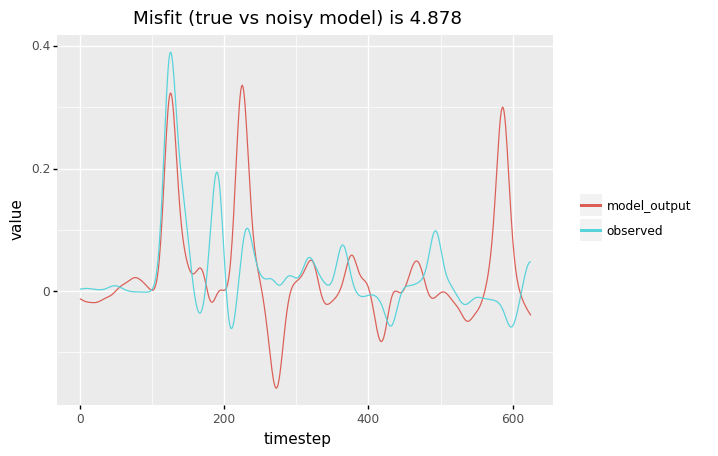

<ggplot: (8751567190248)>

In [7]:
df = pd.DataFrame(dict(timestep=range(len(pred)),model_output=pred, observed=obs))
p = ggplot(df.melt(id_vars="timestep"), aes(x="timestep",y="value",colour="variable")) + geom_line()
p = p + theme(legend_title=element_blank()) + ggtitle(f"Misfit (true vs noisy model) is {misfit:0.3f}")
p

Now let's run the simple DumbDescent inverse solver for 10s and see if we can improve things


In [8]:
m=Model(earth_model=noisy_model)
desc = DumbDescent(model=m, forward=rfc.cofi_misfit, step=0.2, time=10)
res = desc.run()

Take a look at the results returned from the inverter. These will be different for each inverse solver: but here we get the best fitting model, the misfit of that model, how the misfit changed over time during inversion (i.e. during multiple calls to `cofi_misfit()`) and some other information returned from `cofi_misfit()`

In [9]:
print(res.keys())
model, misfit, pred2 = res['model'], res['misfit'], res['cofi_misfit_results_for_best_model_1']
misfit_by_time = res['misfit_by_time']

dict_keys(['model', 'misfit', 'misfit_by_time', 'cofi_misfit_results_for_best_model_1', 'cofi_misfit_results_for_best_model_2'])


Now lets plot to see how well the best model fits the data. We can show it alongside the original noisy model

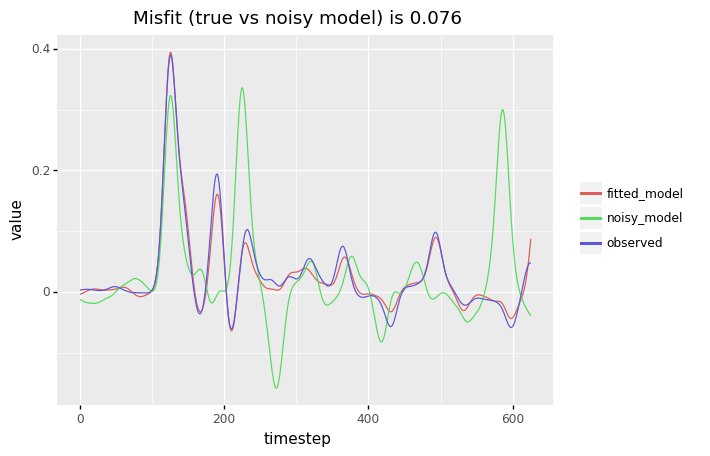

<ggplot: (8751567239533)>

In [10]:
df = pd.DataFrame(dict(timestep=range(len(pred)),noisy_model=pred, fitted_model=pred2, observed=obs))
p = ggplot(df.melt(id_vars="timestep"), aes(x="timestep",y="value",colour="variable")) + geom_line()
p = p + theme(legend_title=element_blank()) + ggtitle(f"Misfit (true vs noisy model) is {misfit:0.3f}")
p

Let's now compare the true model parameters versus the fitted ones

In [11]:
best_fit_params = model.params[0].value

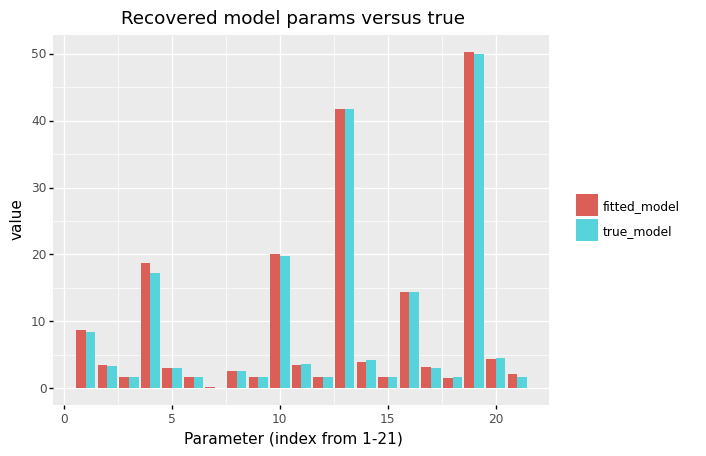

<ggplot: (8751554393607)>

In [12]:
df = pd.DataFrame(dict(idx=range(1,22), fitted_model=best_fit_params.flatten(), true_model=true_model.flatten()))
p = ggplot(pd.melt(df, id_vars="idx")) + geom_bar(aes(x="idx", y="value",fill="variable"), stat="identity", position="dodge")
p = p + theme(legend_title=element_blank()) + ggtitle("Recovered model params versus true") + xlab("Parameter (index from 1-21)")
p

Lastly let's plot how the misfit changed over time

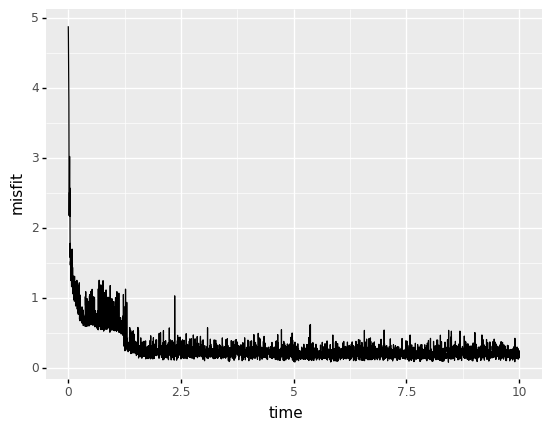

<ggplot: (8751554453845)>

In [13]:
ggplot(pd.DataFrame(misfit_by_time, columns=["time", "misfit"])) + geom_line(aes(x="time", y="misfit"))